# Section 7: Expectation Maximization
Joshua Park

In [1]:
import numpy as np

Let's try applying the expectation-maximization algorithm to the k-means problem.  
Data is drawn from one of $k$ classes, each with unknown mean $μ_i$ for $i = 1,...,k$ and the same standard deviation $σ$. Given a set of observations drawn from this distribution, can we find the $k$ means and assign each datapoint to one of them?  

Our examples will look at data in 2 dimensions, but the code can be used for applications with arbitrarily many dimensions, such as RNA-seq data.

We can begin by identifying our variables and parameters:  
$X$ are the $N$ observations $\vec{x}_i$ for $i = 1, ..., N$  
$Z$ are the cluster identities $z_i$ for $i = 1, ..., N$  
$\Theta$ are the $k$ cluster means $\vec{\mu}_1, ..., \vec{\mu}_k$

For the expectation step, we need to calculate $P(\mu_j | x_i, \Theta)$. For convenience, we can call these probabilities our weights  
$$
  w_j^{(i)} = P(\vec{\mu}_j | \vec{x}_i, \Theta)
$$
To help with this, below is a function to calculate the probability that each sample came from each cluster.

In [67]:
def gaussian_pdf_vectorized(X, means, sigma):
    """
    Vectorized computation of the Gaussian PDF for all points in X with respect to each centroid.
    This function returns the weight matrix using broadcasting.

    Parameters:
    - X: Array of shape (n_samples, n_features), the data points
    - means: Array of shape (k, n_features), the current means
    - sigma: The standard deviation of the Gaussian distribution

    Returns:
    - weights: Array of shape (n_samples, k), the probability of each point belonging to each cluster
    """
    # Compute the squared Euclidean distance between each point and each centroid
    # Using broadcasting: (n_samples, 1, n_features) - (1, k, n_features) => (n_samples, k, n_features)
    diff = X[:, np.newaxis, :] - means[np.newaxis, :, :]
    sq_distances = np.sum(diff ** 2, axis=2)
    
    # Compute the Gaussian PDF for each point with respect to each centroid
    # gaussian_probs corresponds to P(mu, x | Theta)
    gaussian_probs = np.exp(-sq_distances / (2 * sigma ** 2)) / (np.sqrt(2 * np.pi) * sigma)
    
    # Normalize probabilities across clusters for each point (rows sum to 1)
    p = gaussian_probs / gaussian_probs.sum(axis=1, keepdims=True)
    
    return p

In [4]:
def e_step(X, means, sigma):
    """
    E-step: Calculate the weight of each point for each cluster
    based on Gaussian distribution.
    
    Returns:
    - weights: Probability matrix where each element (i, j) is the 
      weight of cluster j for point i.
    """
    return gaussian_pdf_vectorized(X, means, sigma)

For the maximization step, we need to take the weighted average of the data points for each cluster using the weights from the E step.  
The new mean $\mu^{(t+1)}$ at the end of step $t$ is:  
$$
\vec{\mu}^{(t+1)}_j = \frac{1}{\sum_{x_i} w^{(i)}_j} \sum_{x_i} w^{(i)}_j \vec{x}_i
$$

In [68]:
def m_step(X, weights, k):
    """
    M-step: Update means by taking the weighted average of the points
    based on their weights.
    """
    means = np.zeros((k, X.shape[1]))
    for j in range(k):
        weights_j = weights[:, j]
        total_weight = weights_j.sum()
        
        # Compute the weighted mean of points for cluster j
        means[j] = np.sum(X * weights_j[:, np.newaxis], axis=0) / total_weight
    
    return means

In addition to our iterative E and M steps, we also need to start (initialize) and end (convergence) the algorithm.  

For initialization, we want something that is random, and likely to be close to true optimum. Randomly selecting $k$ points randomly from the $N$ data points is one way to do this.

In [3]:
def initialize_means(X, k):
    """
    Randomly initialize the means by selecting k points from the dataset X.
    """
    return X[np.random.choice(X.shape[0], k, replace=False)]

For convergence, we can explicitly calculate the log likelihood and terminate when it stops changing (change less than some threshold). More easily, we can instead look to see if the means stop changing. 

In [12]:
def has_converged(old_means, new_means, tol=1e-4):
    """
    Check if the means have converged (if the movement of means is less than the tolerance).
    """
    return np.all(np.linalg.norm(new_means - old_means, axis=1) < tol)

Now, we can put everything together to run our EM algorithm. In reality, you will want to repeat this process with multiple initializations, but we will do it only once here for visualization purposes.

In [13]:
def em_gaussian_kmeans(X, k, sigma, max_iters=100, tol=1e-4):
    """
    EM algorithm for Gaussian Mixture-based K-means clustering.
    
    Parameters:
    - X: Input data (numpy array of 2D points)
    - k: Number of clusters
    - sigma: Standard deviation of the Gaussian distributions for each cluster
    - max_iters: Maximum number of iterations to run
    - tol: Tolerance for convergence
    
    Returns:
    - all_means: List of means at each iteration
    - weights: Final weight matrix
    """
    means = initialize_means(X, k)
    all_means = [means.copy()]  # Track means at each step
    
    for i in range(max_iters):
        old_means = means
        weights = e_step(X, means, sigma)  # E-step
        means = m_step(X, weights, k)  # M-step
        all_means.append(means.copy())  # Save the means
        
        if has_converged(old_means, means, tol):
            print(f"Converged after {i+1} iterations.")
            break
    
    return all_means, weights

In [17]:
# Example usage:
X = np.array([[1, 2], [1, 4], [1, 0], 
              [10, 2], [10, 4], [10, 0]])  # Example 2D points

k = 2  # Number of clusters
sigma = 1.0  # Standard deviation for the Gaussian distribution
all_means, weights = em_gaussian_kmeans(X, k, sigma)

print("Final means:", all_means[-1])
print("weights (cluster probabilities for each point):")
print(weights)

Converged after 4 iterations.
Final means: [[5.5        3.31981414]
 [5.5        0.68018586]]
weights (cluster probabilities for each point):
[[0.5       0.5      ]
 [0.9949303 0.0050697]
 [0.0050697 0.9949303]
 [0.5       0.5      ]
 [0.9949303 0.0050697]
 [0.0050697 0.9949303]]


## Visualizing the Algorithm
Now, here's a function to generate a dataset to test the algorithm on.

In [22]:
def generate_kmeans_dataset(means, probs=None, sigma=1.0, N=1000):
    """
    Generate a dataset for K-Means clustering.

    Parameters:
    - means: Array of shape (k, D), where k is the number of means and D is the number of dimensions.
    - probs: Optional array of shape (k,), where each element is the probability of selecting the corresponding mean.
             If None, probabilities will be initialized uniformly at random.
    - sigma: Standard deviation for the normal distribution.
    - N: Total number of points to generate.

    Returns:
    - X: Generated dataset of shape (N, D), where N is the number of points.
    - labels: Array of shape (N,), indicating which mean each point was generated from.
    """
    k, D = means.shape  # Number of means and dimensions
    
    # If probs is not provided, generate uniform random probabilities and normalize them
    if probs is None:
        probs = np.random.rand(k)
        probs /= probs.sum()  # Normalize to sum to 1
    
    assert len(probs) == k, "The length of probs must match the number of means"
    
    # Normalize the probabilities in case they don't sum to 1 (just in case)
    probs = np.array(probs)
    probs /= probs.sum()
    
    # Randomly select which mean to use for each point based on the given probabilities
    chosen_means_indices = np.random.choice(np.arange(k), size=N, p=probs)
    
    # Generate points for each chosen mean, normally distributed around that mean
    X = np.zeros((N, D))
    for i in range(N):
        mean_idx = chosen_means_indices[i]
        X[i] = np.random.normal(loc=means[mean_idx], scale=sigma, size=D)
    
    return X, chosen_means_indices

And create a function to visualize the results.

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animate(X, all_means, labels=None, xlim = (0, 12), ylim = (0, 6)):
    """
    Animate the movement of means during iterations, with optional coloring by labels.
    
    Parameters:
    - X: Data points of shape (N, D).
    - all_means: List of means at each iteration, where each entry is of shape (k, D).
    - labels: Optional array of shape (N,), indicating the label of each point. If provided, points
              will be colored by their labels.
    
    Returns:
    - ani: The animation object.
    """
    
    def update(frame):
        plt.clf()  # Clear the previous plot
        means = all_means[frame]  # Get the means for the current frame
        
        # If labels are provided, color by label; otherwise, use a uniform color
        if labels is not None:
            plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=100, alpha=0.6, label='Data Points')
        else:
            plt.scatter(X[:, 0], X[:, 1], color='blue', s=100, alpha=0.6, label='Data Points')
        
        # Plot means for the current step
        plt.scatter(means[:, 0], means[:, 1], c='red', marker='x', s=200, label='Means')
        
        plt.title(f"Iteration {frame+1}")
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.legend()
    
    # Create the animation
    fig, ax = plt.subplots()
    num_frames = len(all_means)  # Number of iterations
    
    ani = FuncAnimation(fig, update, frames=num_frames, repeat=True)
    
    return ani.to_jshtml()

### Generate the dataset
Feel free to play around with the input parameters (means, number of datapoints, standard deviation).

In [64]:
# Example usage:
# Define 3 means in 2D space
means = np.array([[2,3], [1,4], [8,5], [10,2]])
# Standard deviation for the normal distribution
sigma = 1.0
# Number of points to generate
N = 500

# Generate dataset with random probabilities (no probs provided)
X, labels = generate_kmeans_dataset(means, sigma=sigma, N=N)

print("Generated dataset shape:", X.shape)
print("Labels shape:", labels.shape)

Generated dataset shape: (500, 2)
Labels shape: (500,)


### Run the algorithm

In [65]:
k = 3  # Number of clusters
all_means, weights = em_gaussian_kmeans(X, k, sigma)

print("Final means:", all_means[-1])
# print("weights (cluster probabilities for each point):")
# print(weights)

Converged after 24 iterations.
Final means: [[7.71172904 5.26590361]
 [8.47877168 3.75268029]
 [1.41231975 3.70958679]]


### And visualize!

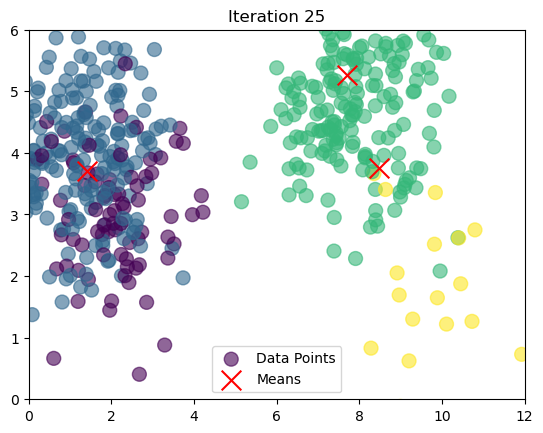

In [70]:
HTML(animate(X, all_means, labels))